Group: 9

Members: LUK YIN WAI, WAT HO YIN, LI CHUN WAI, TSOI YIU CHIK

## 1.	Introduction

To indicate the detection of the content generated by Artificial Intelligence Generated Content (AIGC), both Vision Transformer-Based (ViT-b) and Swin Transformer can distinguish. ViT is a self-attention mechanism that is a powerful model to detect some inconsistencies on capturing between local and global image patterns from AIGC (Wang, 2025). Swin transformer is also a good way to classify that directly process from the raw data as it is a deep learning architecture on processing a large scale of images with hierarchical representations. It results in high efficiency on capturing the long-range spatial dependencies (Mehta et al., 2025).

## 2.	Data preprocessing

### 2.1.	Dataset Splitting
For all training and validation attempts, the project applies a training-validation ratio of 8.5:1.5.

### 2.2.	Data Augmentation
To generalise the model, data augmentations were applied to the training dataset, as the followings. 



## 3.	Attempted approaches
### 3.1.	Pure Swin approach

A pure Swin Transformer approach is a hierarchical structure to build multi-resolution feature maps with self-attention windows on small-sized patches and shifted windows (Liu et al., 2021). Therefore, it is one of the methods as the backbone for vision tasks.
The workflow of Swin Transformer can be divided into four stages that are composed of LayerNorm, Multi-Head Self-Attention (MSA), MLP, and residual.
The architecture of Swin Transformer introduces a hierarchical vision transformer. It begins with dividing the input RGB image into non-overlapping patches which are size 4x4. These non-overlapping patches are treated as tokens, the feature dimension of each patch is  4 ×4 ×3 =48. A linear embedding layer is applied to the raw feature and projects it to an arbitrary dimension C.
The first stage of the architecture is that the Swin Transformer blocks are applied to the token while maintaining the number of tokens as H/4×W/4. Starting from the second phase, the patch merging layers reduce the number of tokens. Each 2x2 group of patches will be merged to reduce the token by 4x and increase the feature dimension to 2C. Therefore, from stage 2 to 4, the resolution and feature dimension are as follows: 

### Stage 2:
$$
\frac{h}{8} \times \frac{w}{8} \times 2C
$$

### Stage 3:
$$
\frac{h}{16} \times \frac{w}{16} \times 4C
$$

### Stage 4:
$$
\frac{h}{32} \times \frac{w}{32} \times 8C
$$


The Swin Transformer used a shifted window mechanism to solve the problem of computational inefficiency.  Swin Transformer limits the self-attention to non-overlapping local windows to reduce complexity. For the Local Window-Based Self-Attention (W-MSA), the self-attention is applied within M x M non-overlapping windows. For the Shifted Windows (SW-MAS), they are used to introduce the cross-window connections; therefore, the second Swin Transformer block would shift the window by M/2,M/2, which allows tokens near the borders of the window in one layer to interact with tokens in neighboring windows in the next layer. The computation in two consecutive Swin Transformer blocks is as follows:

### (W-MSA)

$$
\hat{z}^{l} = \text{W-MSA}(\text{LN}(z^{l-1})) + z^{l-1}
$$

$$
z^{l} = \text{MLP}(\text{LN}(\hat{z}^{l})) + \hat{z}^{l}
$$



### (SW-MSA)

$$
\hat{z}^{l+1} = \text{SW-MSA}(\text{LN}(z^{l})) + z^{l}
$$

$$
z^{l+1} = \text{MLP}(\text{LN}(\hat{z}^{l+1})) + \hat{z}^{l+1}
$$

Where $(\hat{z}^l, z^l)$ denote the output features of the W-MSA and MLP modules for block $l$.

To solve the problem of the padding and masking overhead when the window image size is not divisible by the window size, the cyclic shift strategy has been used in Swin Transformer. Cyclic shift is to shift the feature map before window partitioning, and this could maintain the same number of windows as regular. And after a cyclic shift, a masking mechanism is used to compute the attention within the windows, to avoid the interactions between patches that are not in the same shifted window.

The equation below is used for computing the similarity score by adding a learnable relative position bias (B). It also takes queries (Q), keys (K), and values (V). To normalize the score, SoftMax is applied to get the attention weights to each local window.

$$
\text{Attention}(Q, K, V) = \text{SoftMax}\left(\frac{QK^T}{\sqrt{d}} + B\right)V
$$

The python notebook of this pure Swin method is also included. 

### 3.2.	Pure ViT-L approach

A pure ViT-L/16 model used image patches, which are tokens instead of words. First, it splits an image into fixed patches and processes them with a standard Transformer encoder. For classification use, an extra class token output is used (Dosovitskiy et al., 2020). The workflow is the following:

#### 1. Reshape the image

$$
x \in \mathbb{R}^{H \times W \times C} \rightarrow x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}
$$

The input image $x \in \mathbb{R}^{H \times W \times C}$ where **H** and **W** are the height and width and **C** is the number of channels. After dividing into multiple patches of size $P \times P$ and the total have $N = \frac{HW}{P^2}$. Each patch is _flattened_ into the length of $P^2 \cdot C$ to form $x_p \in \mathbb{R}^{N \times (P^2 \cdot C)}$.

#### 2. Patch embedding and add class token

$$
z_0 = [x_{\text{class}}; x_p^1 E; x_p^2 E; \ldots; x_p^N E] + E_{\text{pos}}
$$

A learnable class token $x_{\text{class}} \in \mathbb{R}^D$ is put in the front of the patch embeddings where a 1-D dimensional positional embedding $E_{\text{pos}} \in \mathbb{R}^{(N+1) \times D}$ is added to encode patch order to the Transformer encoder.


#### 3. Transformer encoder

##### 3.1 Multi-Head Self-Attention (MSA) block

$$
z_\ell' = \text{MSA}(\text{LN}(z_{\ell - 1})) + z_{\ell - 1}, \quad \ell = 1, \ldots, L
$$

MSA is used to make each token _context-aware_. LN is to normalize the input, and the residual is added with the addition of the original and attention input.


##### 3.2 MLP block

$$
z_\ell = \text{MLP}(\text{LN}(z_\ell')) + z_\ell', \quad \ell = 1, \ldots, L
$$

After doing MSA, MLP block then transforms each token’s features nonlinearly, which lets the model build a more complex representation.

##### 4. Extract image representation and classification

$$
y = \text{LN}(z_L^0)
$$

For the final sequence, **LayerNorm** is applied, and $y$ is the vector at the class token index as the image representation. Both pre-training and fine-tuning will attach to the classification head, which is $z_L^0$.


### 3.3.	VitB + Swin approach

To take advantage of both transformer models, the CNN learns with the concatenated feature extracted from both models, as shown below. 

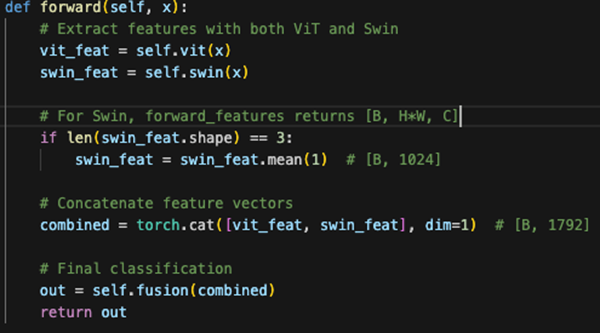

The python notebook for training the combined method is also included.



### 3.4.	Pure ViT-L approach with frozen and unfrozen layers.

In this approach, frozen and unfrozen layers approach is tested. Due to time limitations, only ViT-L is used for this approach. 30% epochs will be used as frozen layers at first which the weights are not updated during training. After that, backbone is unfrozen for the remaining 70% epochs which the weights are trainable and will be updated during training. Frozen layers are used for not changing the pre-trained knowledge. Unfrozen layers are used to fine-tuning on specific dataset.


## 4.	Model Evaluations

### 4.1.	Training Dataset

| Model                   | Training Epochs | Precision | Recall  | F1-Score | Accuracy |
|------------------------|-----------------|-----------|---------|----------|----------|
| ViTB + Swin            | 5               | 0.9998    | 0.9998  | 0.9998   | 0.9998   |
|                        | 10              | 1         | 1       | 1        | 1        |
|                        | 15              | 1         | 1       | 1        | 1        |
| Swin                   | 5               | 0.9997    | 0.9997  | 0.9997   | 0.9997   |
|                        | 10              | 0.9999    | 0.9999  | 0.9999   | 0.9999   |
|                        | 15              | 1         | 1       | 1        | 1        |
| ViT-L                  | 5               | 0.9889    | 0.9889  | 0.9889   | 0.9889   |
|                        | 10              | 0.9943    | 0.9943  | 0.9943   | 0.9943   |
|                        | 15              | 0.9951    | 0.9951  | 0.9951   | 0.9951   |
| ViT-L (Frozen+Unfrozen)| 5               | 0.9883    | 0.9883  | 0.9883   | 0.9883   |
|                        | 10              | 0.9902    | 0.9902  | 0.9902   | 0.9902   |
|                        | 15              | 0.9945    | 0.9945  | 0.9945   | 0.9945   |

### 4.2.	Validation Dataset

| Model                   | Training Epochs | Precision | Recall  | F1-Score | Accuracy |
|------------------------|-----------------|-----------|---------|----------|----------|
| ViTB + Swin            | 5               | 0.9978    | 0.9978  | 0.9978   | 0.9978   |
|                        | 10              | 0.9990    | 0.9990  | 0.9990   | 0.9990   |
|                        | 15              | 0.9990    | 0.9990  | 0.9990   | 0.9990   |
| Swin                   | 5               | 0.9980    | 0.9980  | 0.9980   | 0.9980   |
|                        | 10              | 0.9983    | 0.9983  | 0.9983   | 0.9983   |
|                        | 15              | 0.9981    | 0.9981  | 0.9981   | 0.9981   |
| ViT-L                  | 5               | 0.9977    | 0.9977  | 0.9977   | 0.9977   |
|                        | 10              | 0.9971    | 0.9971  | 0.9971   | 0.9971   |
|                        | 15              | 0.9991    | 0.9991  | 0.9991   | 0.9991   |
| ViT-L (Frozen+Unfrozen)| 5               | 0.9948    | 0.9948  | 0.9948   | 0.9948   |
|                        | 10              | 0.9988    | 0.9988  | 0.9988   | 0.9988   |
|                        | 15              | 0.9996    | 0.9996  | 0.9996   | 0.9996   |

### 4.3.	Kaggle Submission

For the Kaggle test set, the Pure Swin model achieves an accuracy between 0.67 to 0.69. Specifically, the accuracy score shown in the following figure increases as the model is trained with fewer epochs. Such results may reflect the existence of overfitting. 

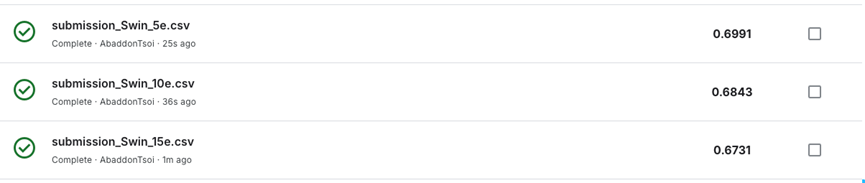

The combined models of ViTB and Swin with different training epochs had achieved the following score on Kaggle’s dataset; the one with 15 epochs achieved the best result. 

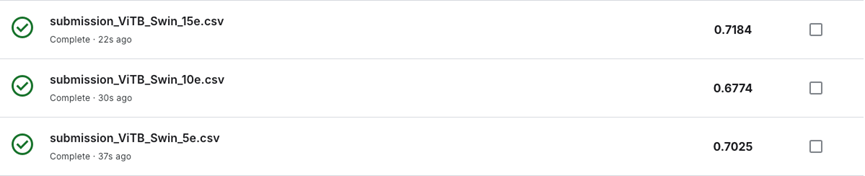

The ViTL with different training epochs had achieved the following score on Kaggle’s dataset, the one with 15 epochs achieved the best result. 

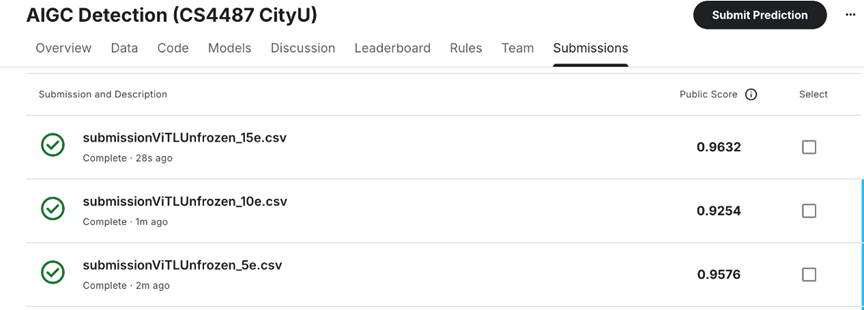

Throughout all the Kaggle test set ViT-L with frozen and unfrozen layers approach get the best result which 15 epoch get the best result.

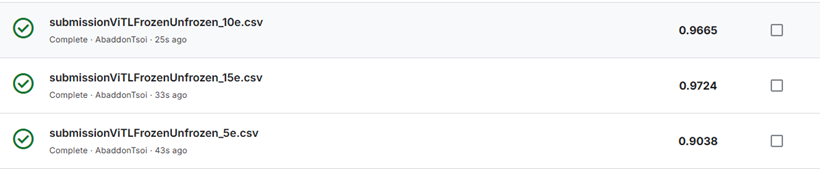

# Code for training the model

**Install Packages**

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install timm tqdm pillow scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121
     ---------------------------------------- 0.0/2.4 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.4 GB 88.9 MB/s eta 0:00:28
     ---------------------------------------- 0.0/2.4 GB 65.6 MB/s eta 0:00:38
     ---------------------------------------- 0.0/2.4 GB 63.5 MB/s eta 0:00:39
     ---------------------------------------- 0.0/2.4 GB 65.6 MB/s eta 0:00:38
     ---------------------------------------- 0.0/2.4 GB 73.1 MB/s eta 0:00:34
     ---------------------------------------- 0.0/2.4 GB 81.8 MB/s eta 0:00:30
     ---------------------------------------- 0.0/2.4 GB 108.8 MB/s eta 0:00:23
     ---------------------------------------- 0.0/2.4 GB 108.8 MB/s eta 0:00:23
      --------------------------------------- 0.0/2.4 GB 93.9 MB/s eta 0:00:26
      --------------------------------------- 0.0/2.4 GB 72.6 MB/s eta 0:00:34
      --------------------------------------- 0.0/2.4 GB 110.0 MB/s eta 0:00:2


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import packages
import os
import random
import shutil
import multiprocessing
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.autoaugment import RandAugment
from timm import create_model
import csv
import json
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
# Setup
batch_size_frozen = 64
batch_size_unfrozen = 64  
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers = 12  # safe high-performance for gpu working

In [ ]:
# === Transforms ===
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    RandAugment(num_ops=2, magnitude=9),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.15), ratio=(0.3, 3.3), value='random'),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
# === Dataset Split ===
# Requires an unzipped data folder with following structure:
# data/
#  |---train
#       |---0_real/
#       |---1_fake/
def split_train_to_val(source_dir, val_ratio=0.15, seed=42):
    source_dir = Path(source_dir)
    val_dir = source_dir.parent / "val"
    random.seed(seed)
    classes = ["0_real", "1_fake"]

    for class_name in classes:
        train_class_dir = source_dir / class_name
        val_class_dir = val_dir / class_name

        if not train_class_dir.exists():
            print(f"Skipping missing class folder: {train_class_dir}")
            continue

        # Skip if already split
        if val_class_dir.exists() and any(val_class_dir.iterdir()):
            print(f"Validation folder already exists and is not empty: {val_class_dir}. Skipping.")
            continue

        val_class_dir.mkdir(parents=True, exist_ok=True)

        # Get image files
        image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
        files = [f for f in train_class_dir.iterdir() if f.suffix.lower() in image_extensions and f.is_file()]
        if not files:
            print(f"No images found in {train_class_dir}. Skipping.")
            continue

        num_to_copy = max(1, int(len(files) * val_ratio))
        files_to_copy = random.sample(files, num_to_copy)

        print(f"Copying {num_to_copy}/{len(files)} images from {class_name} to validation")

        for f in files_to_copy:
            dest = val_class_dir / f.name
            shutil.copy(str(f), str(dest))

    print(f"\nValidation set created at: {val_dir}")

In [ ]:
# === Dataset Class ===
class data_loader(Dataset):
    def __init__(self, data_dir, transform=None):
        real = os.path.join(data_dir, '0_real')
        fake = os.path.join(data_dir, '1_fake')
        self.full_filenames = [os.path.join(real, f) for f in os.listdir(real)] + \
                              [os.path.join(fake, f) for f in os.listdir(fake)]
        self.labels = [0]*len(os.listdir(real)) + [1]*len(os.listdir(fake))
        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx]).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
# === Model ===
class CNN(nn.Module):
    def __init__(self, pretrained=True, freeze_backbone=True, dropout=0.3):
        super(CNN, self).__init__()
        self.vit = create_model('vit_large_patch16_224', pretrained=pretrained, num_classes=0)
        self.freeze_backbone = freeze_backbone

        if freeze_backbone:
            for param in self.vit.parameters():
                param.requires_grad = False

        # Additional fusion layer
        self.fusion = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        # Extract features
        feat = self.vit(x)
        return self.fusion(feat)

    def unfreeze_backbone(self):
        for param in self.vit.parameters():
            param.requires_grad = True
        self.freeze_backbone = False

In [ ]:
# === Train Function ===
def train():
    data_root = "data"
    total_epochs = 5
    freeze_epochs = 2
    lr_frozen = 1e-4
    lr_unfrozen = 1e-5

    metrics_log = {
        "train_loss": [],
        "train_acc": [],
        "train_prec": [],
        "train_rec": [],
        "train_f1": [],
        "val_acc": [],
        "val_prec": [],
        "val_rec": [],
        "val_f1": []
    }

    split_train_to_val(os.path.join(data_root, "train"), val_ratio=0.15)
    train_dataset = data_loader(os.path.join(data_root, "train"), transform=train_transform)
    val_dataset = data_loader(os.path.join(data_root, "val"), transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size_frozen, shuffle=True,
                              num_workers=num_workers, pin_memory=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_frozen, shuffle=False,
                            num_workers=num_workers, pin_memory=False)

    model = CNN(pretrained=True, freeze_backbone=True).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_frozen)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(total_epochs):
        if epoch == freeze_epochs and model.freeze_backbone:
            print(f"Unfreezing ViT backbone at epoch {epoch+1}")
            model.unfreeze_backbone()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr_unfrozen)
            train_loader = DataLoader(train_dataset, batch_size=batch_size_unfrozen,
                                      shuffle=True, num_workers=num_workers, pin_memory=False)

        model.train()
        total_loss, total_correct, total = 0, 0, 0
        train_preds, train_targets = [], []
        loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch [{epoch+1}/{total_epochs}]")

        for imgs, labels in loop:
            imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type="cuda"):
                outputs = model(imgs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * imgs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()
            total += imgs.size(0)

            train_preds.extend(outputs.argmax(1).detach().cpu().tolist())
            train_targets.extend(labels.detach().cpu().tolist())

        train_loss = total_loss / total
        train_acc = accuracy_score(train_targets, train_preds)
        train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
            train_targets, train_preds, average='macro', zero_division=0
        )

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                preds = outputs.argmax(1)
                val_preds.extend(preds.detach().cpu().tolist())
                val_targets.extend(labels.detach().cpu().tolist())

        val_acc = accuracy_score(val_targets, val_preds)
        val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
            val_targets, val_preds, average='macro', zero_division=0
        )

        metrics_log["train_loss"].append(train_loss)
        metrics_log["train_acc"].append(train_acc)
        metrics_log["train_prec"].append(train_prec)
        metrics_log["train_rec"].append(train_rec)
        metrics_log["train_f1"].append(train_f1)
        metrics_log["val_acc"].append(val_acc)
        metrics_log["val_prec"].append(val_prec)
        metrics_log["val_rec"].append(val_rec)
        metrics_log["val_f1"].append(val_f1)

        print(f"Epoch {epoch+1}/{total_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f} || "
              f"Val Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")

    torch.save(model.state_dict(), "model.pth")
    print("Model saved to model.pth")

    # === Save metrics ===
    os.makedirs("logs", exist_ok=True)
    csv_path = "logs/vit_all_metrics_frozen_5e.csv"
    json_path = "logs/vit_all_metrics_frozen_5e.json"

    with open(csv_path, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "Epoch", "Train_Loss", "Train_Acc", "Train_Prec", "Train_Rec", "Train_F1",
            "Val_Acc", "Val_Prec", "Val_Rec", "Val_F1"
        ])
        for i in range(total_epochs):
            writer.writerow([
                i + 1,
                f"{metrics_log['train_loss'][i]:.4f}",
                f"{metrics_log['train_acc'][i]:.4f}",
                f"{metrics_log['train_prec'][i]:.4f}",
                f"{metrics_log['train_rec'][i]:.4f}",
                f"{metrics_log['train_f1'][i]:.4f}",
                f"{metrics_log['val_acc'][i]:.4f}",
                f"{metrics_log['val_prec'][i]:.4f}",
                f"{metrics_log['val_rec'][i]:.4f}",
                f"{metrics_log['val_f1'][i]:.4f}"
            ])

    with open(json_path, 'w') as f:
        json.dump(metrics_log, f, indent=2)

    print(f"Metrics saved to {csv_path} and {json_path}")


In [ ]:
# === Entry Point ===
if __name__ == "__main__":
    train()

# Test the model

To test the model, you may open and run the test.ipynb 

<style>
.hanging-indent {
    padding-left: 1.5em;
    text-indent: -1.5em;
    line-height: 1.6;
}
</style>

## References

<div class="hanging-indent">
Wang, H. (2025). Vision Transformer-based framework for AI-generated image detection in interior design. <i>Informatica, 49</i>(16). <br>https://doi.org/10.31449/inf.v49i16.7979  
</div>

<div class="hanging-indent">
Mehta, P., Sagar, A., & Kumari, S. (2025). Enhancing image authenticity detection: Swin Transformers and color frame analysis for CGI vs. real images. <i>Procedia Computer Science, 258</i>, 2695–2702. <br>https://doi.org/10.1016/j.procs.2025.04.530  
</div>

<div class="hanging-indent">
Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020). An image is worth 16×16 words: Transformers for image recognition at scale. <i>arXiv</i>. <br>https://arxiv.org/abs/2010.11929  
</div>

<div class="hanging-indent">
Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., Lin, S., & Guo, B. (2021). Swin Transformer: Hierarchical vision transformer using shifted windows. <i>2021 IEEE/CVF International Conference on Computer Vision (ICCV)</i>, 9992–10002. <br>https://doi.org/10.1109/iccv48922.2021.00986  
</div>